In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#OpenCV contrib
Instal openCV Contrib as SIFT is patented and cannot be found in latest versions of openCV.

In [0]:
!pip install opencv-contrib-python==3.4.2.17

#Import necessary Libraries

In [0]:
import numpy as np
import argparse
import imutils
import cv2
import glob
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

#Loading Dataset

In [0]:
images_1 = [cv2.imread(file) for file in glob.glob("/content/drive/My Drive/VR/Image stitching/*a.jpg")]
images_2 = [cv2.imread(file) for file in glob.glob("/content/drive/My Drive/VR/Image stitching/*b.jpg")]

#Data Preprocessing

In [0]:
#Function to resize image

def standardize_input(image):
    
    # Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image, (700, 400))
    
    return standard_im

In [0]:
#Function to convert image to grayscale

def convert_gray(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return gray

In [0]:
#Resizing and converting to grayscale

gray_1 = []
gray_2 = []
resize_1 = []
resize_2 = []
for img_1 in images_1:
  img_1 = standardize_input(img_1)
  resize_1.append(img_1)
  gray1 = convert_gray(img_1)
  gray_1.append(gray1)

for img_2 in images_2:
  img_2 = standardize_input(img_2)
  resize_2.append(img_2)
  gray2 = convert_gray(img_2)
  gray_2.append(gray2)

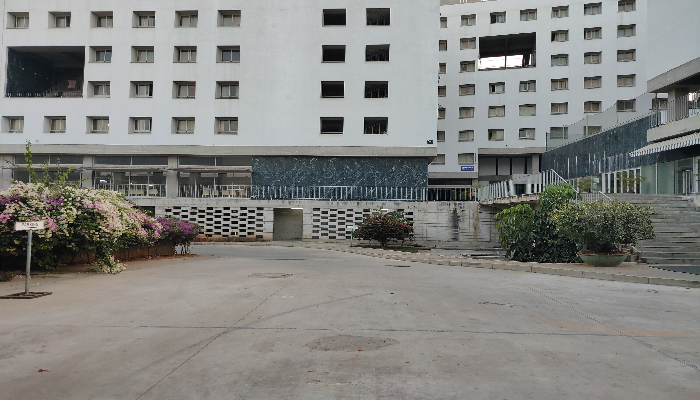

In [0]:
#display left image for stitching

cv2_imshow(img_1)

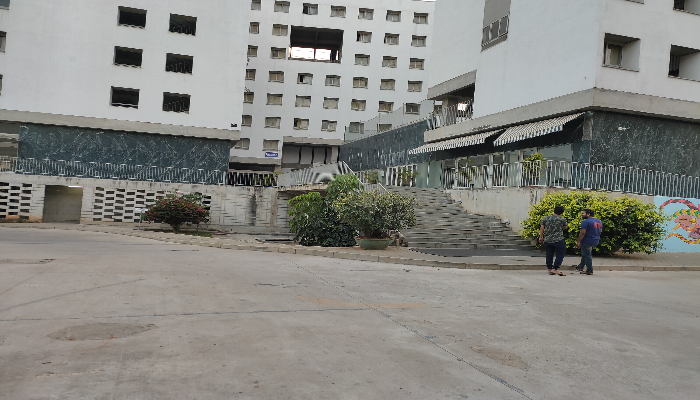

In [0]:
#display right image for stitching

cv2_imshow(img_2)

#Feature Extraction

In [0]:
#SIFT 

sift = cv2.xfeatures2d.SIFT_create()
kp_1 = []
kp_2 = []
des_1 = []
des_2 = []
for i in gray_1:
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(i,None)
  kp_1.append(kp1)
  des_1.append(des1)
  
for i in gray_2:
  kp2, des2 = sift.detectAndCompute(i,None)
  kp_2.append(kp2)
  des_2.append(des2)

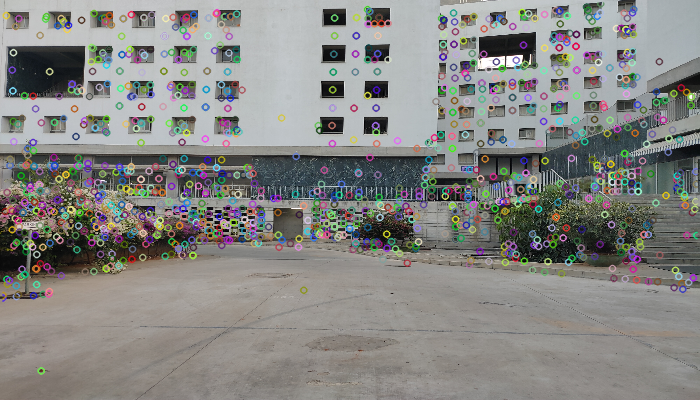

In [0]:
#Displaying key points in one image

show_1 = cv2.drawKeypoints(img_1, kp1, outImage = None)
cv2_imshow(show_1)

#Matching Keypoints in two images

In [0]:
#Using Brute Force Matcher using KNN Algorithm

matches = []
match = []
bf = cv2.BFMatcher()
for i,j in zip(des_1,des_2):
  match = bf.knnMatch(i,j, k=2)
  matches.append(match)

In [0]:
#Selecting only good matches whose distance ratio is less than 0.5

gp_arr = []
gm_arr = []
for i in matches:
  good_points = []
  good_matches = []
  for m1, m2 in i:
    if m1.distance < 0.5 * m2.distance:
      good_points.append((m1.trainIdx, m1.queryIdx))
      good_matches.append([m1])
  gp_arr.append(good_points)
  gm_arr.append(good_matches)


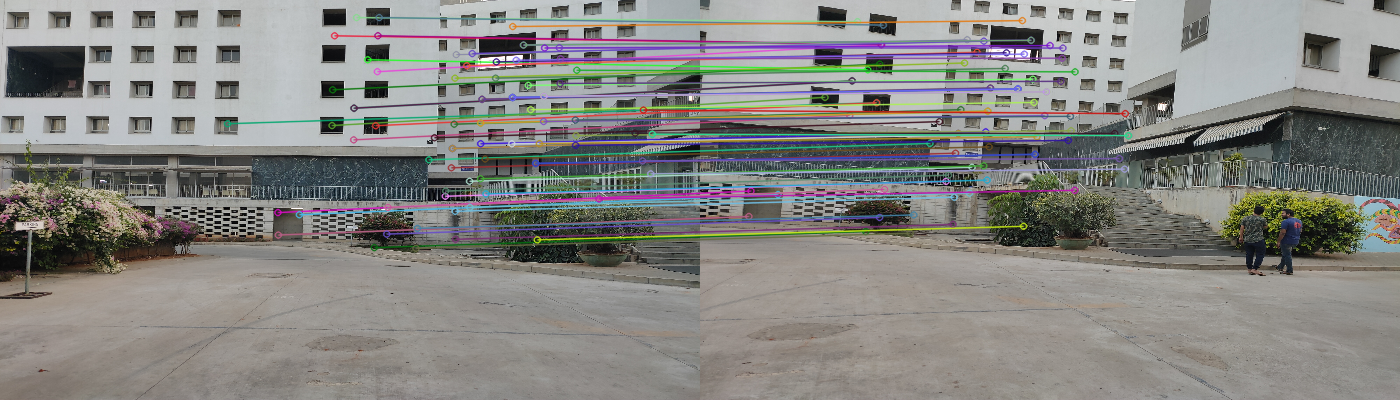

In [0]:
#Displaying matches

show_2 = cv2.drawMatchesKnn(img_1, kp1, img_2, kp2, good_matches, None, flags=2)
cv2_imshow(show_2)

#Homography

In [0]:
#Using RANSAC Algorithm for eleminating outliers

H_arr = []
for good_points,kp1,kp2 in zip(gp_arr,kp_1,kp_2):
  if len(good_points) >= 4:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
  H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
  H_arr.append(H)

#Final Image Stitching

In [0]:
def get_stitched_image(img1, img2, M):

	# Get width and height of input images	
	w1,h1 = img1.shape[:2]
	w2,h2 = img2.shape[:2]

	# Get the canvas dimesions
	img1_dims = np.float32([ [0,0], [0,w1], [h1, w1], [h1,0] ]).reshape(-1,1,2)
	img2_dims_temp = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)


	# Get relative perspective of second image
	img2_dims = cv2.perspectiveTransform(img2_dims_temp, M)

	# Resulting dimensions
	result_dims = np.concatenate( (img1_dims, img2_dims), axis = 0)

	# Getting images together
	# Calculate dimensions of match points
	[x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
	[x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
	
	# Create output array after affine transformation 
	transform_dist = [-x_min,-y_min]
	transform_array = np.array([[1, 0, transform_dist[0]], 
								[0, 1, transform_dist[1]], 
								[0,0,1]]) 

	# Warp images to get the resulting image
	result_img = cv2.warpPerspective(img2, transform_array.dot(M), 
									(x_max-x_min, y_max-y_min))
	result_img[transform_dist[1]:w1+transform_dist[1], 
				transform_dist[0]:h1+transform_dist[0]] = img1

	# Return the result
	return result_img

#Displaying Final Output

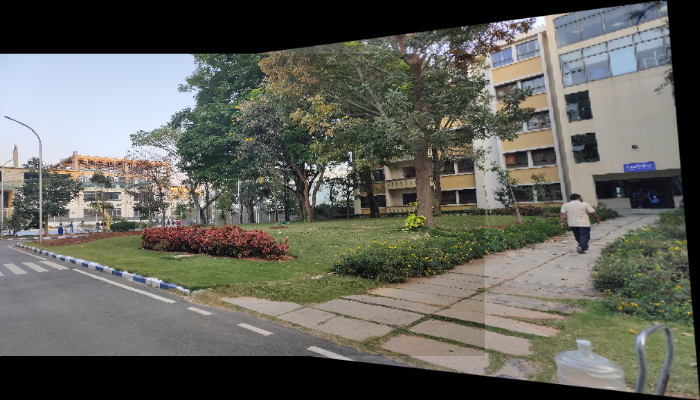

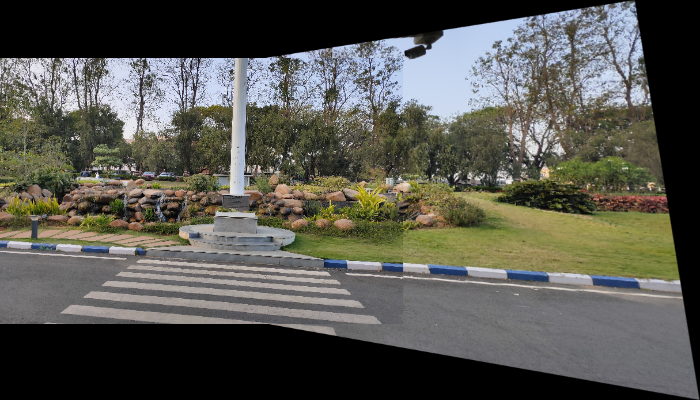

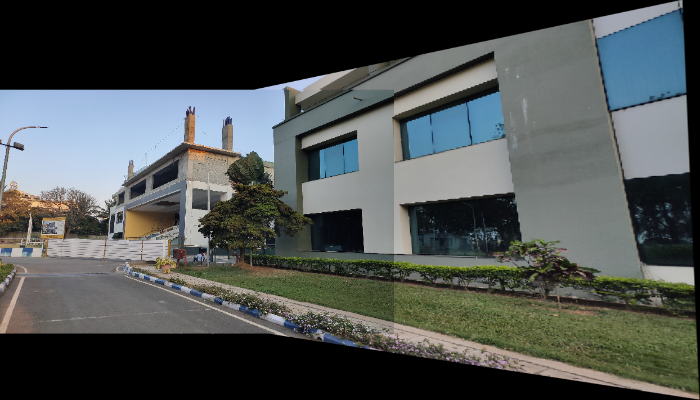

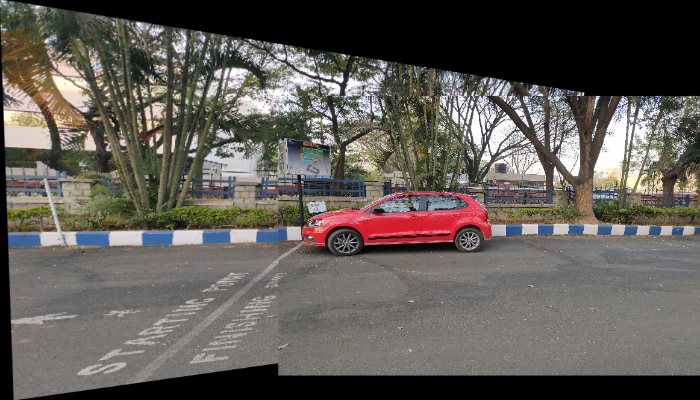

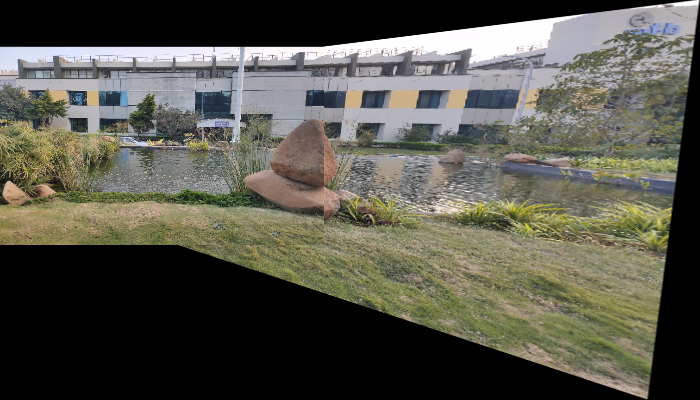

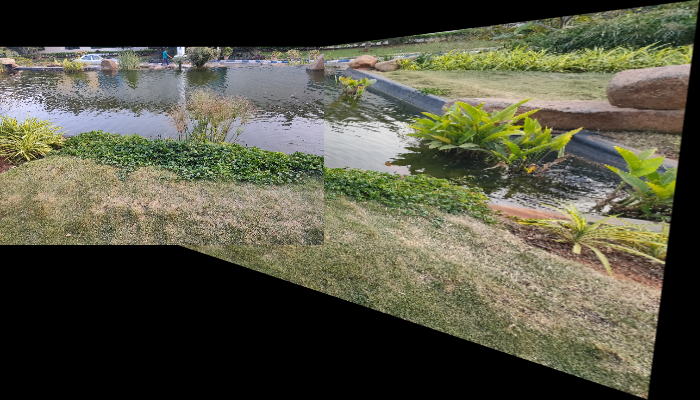

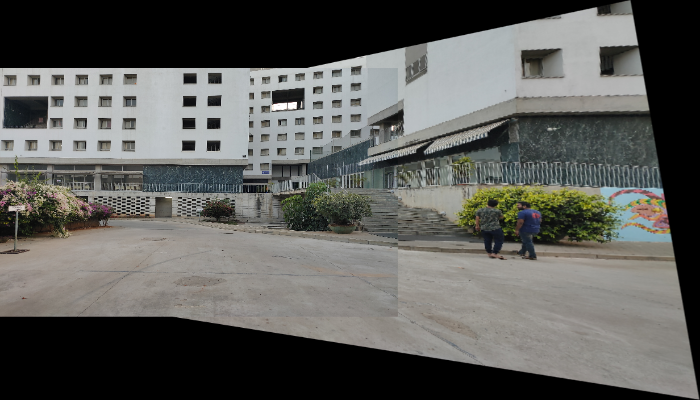

In [0]:
for H,img_1,img_2 in zip(H_arr,resize_1,resize_2):
  result_image = get_stitched_image(img_1, img_2, H)
  final_img = standardize_input(result_image)
  cv2_imshow(final_img)